In [1]:
import numpy, pandas
from utils import intercurvefitdifferentiate

In [2]:
from influxdb import InfluxDBClient, DataFrameClient
fconfig = dict(x.split()  for x in open("fconfig.txt").readlines())
dclient = DataFrameClient(fconfig["host"], 8086, fconfig["username"], fconfig["password"], fconfig["database"])


In [43]:
# zoom in on https://grafana.doesliverpool.xyz/d/XySjJu4Vk/aidan-basement?editPanel=2&orgId=1&from=1667729911548&to=1667804437768 
# and find a range with a clean decay curve in it
co2base = None
t0, t1 = '2022-11-06 14:23:00', '2022-11-06 23:23:00'
#t0, t1 = '2022-11-02 09:00:00', '2022-11-02 13:45:00'
#t0, t1, co2base = '2022-10-19 08:28:00', '2022-10-19 14:14:00', 380

timerange = "time>'%s' and time<'%s'" % (t0, t1)
groupby = "group by time(5m)"

device = "netatmo1"
key = "lowerground"
query = "select mean(co2) as co2_%s from julianhouse where device='%s' and %s %s" % \
            (key, device, timerange, groupby)
s1 = dclient.query(query)

device = "netatmo3"
key = "groundfloor"
query = "select mean(co2) as co2_%s from julianhouse where device='%s' and %s %s" % \
            (key, device, timerange, groupby)
s3 = dclient.query(query)

df = pandas.concat([s1["julianhouse"], s3["julianhouse"]], axis=1).dropna()

if co2base:
    df["co2_groundfloor"] = co2base

df.columns

Index(['co2_lowerground', 'co2_groundfloor'], dtype='object')

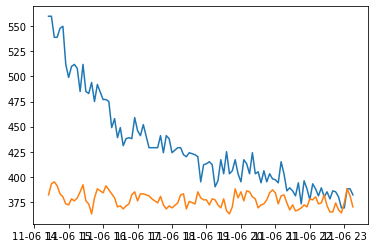

In [44]:
from matplotlib import pyplot as plt
plt.plot(df)

In [45]:
rx = df["co2_lowerground"]
seriestimeindex = pandas.date_range(rx.index[0], rx.index[-1], freq="180s")
rx0, rx1, rx2 = intercurvefitdifferentiate(seriestimeindex, rx, 12000, deg=3)

bx = df["co2_groundfloor"]
seriestimeindex = pandas.date_range(bx.index[0], bx.index[-1], freq="180s")
bx0, bx1, bx2 = intercurvefitdifferentiate(seriestimeindex, bx, 12000, deg=3)
bx0.mean()

376.64394995991086

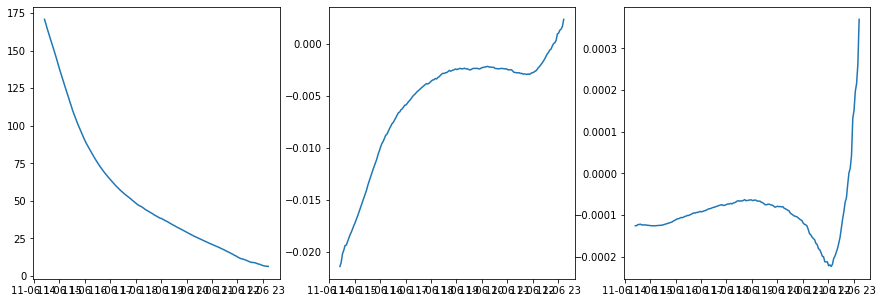

In [46]:
plt.figure(figsize=(15,5))
dx0 = rx0-bx0
plt.subplot(131)
plt.plot(dx0)
plt.subplot(132)
plt.plot(rx1)
plt.subplot(133)
plt.plot(rx1/dx0)

In [21]:
# This looks like Rate of Change of CO2 meading = dy/dt = -0.0001*(y - 376), 
# where 376 is the outside CO2 reading
# This 0.0001 is air changes per second, or 0.36 Air Changes Per Hour

# This is an exponential curve, but we don't need to express it as such because 
# The ACH is a rate of change of air as a percentage of volume, so it's simple.


In [ ]:
#t0, t1 = '2022-11-06 14:23:00', '2022-11-06 23:23:00' => ACH = 0.36
#t0, t1 = '2022-11-02 09:00:00', '2022-11-02 13:45:00' => ACH = 0.54
#t0, t1 = '2022-10-19 08:28:00', '2022-10-19 14:14:00' => ACH = 0.32
